本教程包含DeepDream的最小实现，如Alexander Mordvintsev的此博客文章中所述。

DeepDream是一个可视化神经网络学习模式的实验。类似于孩子看着云并尝试解释随机形状时，DeepDream会过度解释并增强其在图像中看到的图案。

它是通过网络转发图像，然后计算图像相对于特定层的激活的梯度来实现的。然后修改图像以增加这些激活，增强网络可见的图案，并生成类似梦境的图像。这个过程被称为“ Inceptionism”（对InceptionNet和电影 Inception 的引用）。

让我们演示如何使神经网络“梦想”并增强其在图像中看到的超现实模式。

![](https://www.tensorflow.org/tutorials/generative/images/dogception.png?hl=zh_cn)

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import,division,print_function,unicode_literals
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

###选择一张图片以实现梦想
在本教程中，我们使用拉布拉多的图像。

In [0]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

90112/83281 [================================] - 0s 0us/step


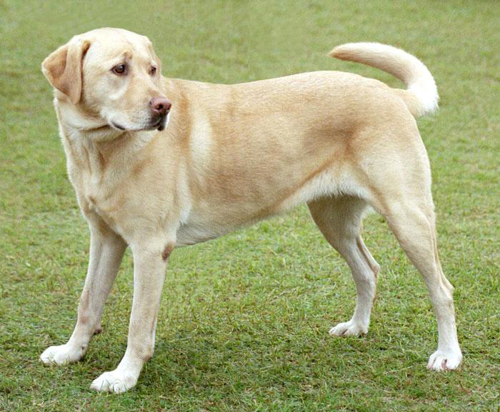

In [4]:
# Download an image and read it into a NumPy array.
def download(url,max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name,origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim,max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img,tf.uint8)

#Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

# Downsizing the image makes it easier to work with.
original_img = download(url,max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

###准备特征提取模型
下载并准备预训练的图像分类模型。您将使用[InceptionV3](https://keras.io/applications/#inceptionv3)，它与DeepDream中最初使用的模型相似。请注意，任何预先训练的模型都可以使用，但是如果您更改此名称，则必须在下面调整图层名称。

In [5]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 2s 0us/step


DeepDream中的想法是选择一个或多个图层，并以使图像越来越“激发”图层的方式最大化“损失”。合并的功能的复杂性取决于您选择的图层，即较低的图层会产生笔触或简单的图案，而较深的图层则会使图像甚至整个对象具有复杂的功能。

InceptionV3架构非常大（有关模型架构的图表，请参见TensorFlow的研究报告）。对于DeepDream，感兴趣的层是将卷积串联在一起的层。InceptionV3中有11个层，名为“ mixed0”至“ mixed10”。使用不同的图层将产生不同的梦幻图像。较深的层对较高级的特征（例如，眼睛和面部）做出响应，而较早的层对较简单的特征（例如，边缘，形状和纹理）做出响应。请随意尝试以下选择的图层，但请记住，由于渐变计算的深度较大，较深的图层（具有较高索引的图层）将需要较长的训练时间。

In [0]:
# Maximize the activations of these layers
names = ['mixed3','mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input,outputs=layers)

###计算损失
损失是所选层中激活的总和。损耗在每一层均归一化，因此较大层的贡献不会超过较小层。通常，损耗是您希望通过梯度下降最小化的数量。在DeepDream中，您将通过梯度上升来最大化此损失。

In [0]:
def calc_loss(img,model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch  = tf.expand_dims(img,axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) ==1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return tf.reduce_sum(losses)


###渐变上升
计算出所选图层的损耗后，剩下的就是计算相对于图像的渐变，并将其添加到原始图像中。

将渐变添加到图像可以增强网络看到的图案。在每个步骤中，您将创建一个图像，该图像将越来越多地激发网络中某些层的激活。

下面将执行此操作的方法包装在中，以[tf.function](https://www.tensorflow.org/api_docs/python/tf/function?hl=zh_cn)提高性能。它使用input_signature来确保不会针对不同的图像大小或steps/ step_size值回溯该函数。有关详细信息，请参见[具体功能指南](https://www.tensorflow.org/guide/concrete_function?hl=zh_cn)。

In [0]:
class DeepDream(tf.Module):
  def __init__(self,model):
    self.model = model

  @tf.function(
      input_signature=(
          tf.TensorSpec(shape=[None,None,3],dtype=tf.float32),
          tf.TensorSpec(shape=[],dtype=tf.int32),
          tf.TensorSpec(shape=[],dtype=tf.float32),
      )
  )
  def __call__(self,img,steps,step_size):
    print("Tracing")
    loss = tf.constant(0.0)
    for n in tf.range(steps):
      with tf.GradientTape() as tape:
        # This needs gradients relative to 'img'
        # 'GradientTape' only watches 'tf.Variable's by default
        tape.watch(img)
        loss = calc_loss(img,self.model)

      #Calculate the gradient of the loss with respect to the pixels of the input image.
      gradients = tape.gradient(loss,img)

      #Normalize the gradients.
      gradients /= tf.math.reduce_std(gradients) + 1e-8

      #In gradient ascent, the "loss" is maximized so that input image increasingly "excites" the layers.
      #You can update the image by directly adding the gradients (because they're the same shape!)
      img = img + gradients*step_size
      img = tf.clip_by_value(img,-1,1)

    return loss,img


In [0]:
deepdream = DeepDream(dream_model)

###主循环

In [0]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining > 100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img,run_steps,tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print("Step {}, loss {}".format(step, loss))

  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

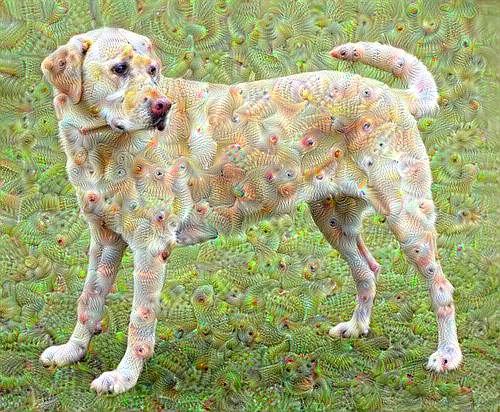

In [14]:
dream_img = run_deep_dream_simple(img=original_img,
                                  steps=100,step_size=0.01)

###调高八度
很好，但是第一次尝试有一些问题：

1. 输出有噪声（可能会[tf.image.total_variation](https://www.tensorflow.org/api_docs/python/tf/image/total_variation?hl=zh_cn)造成损失）。
2. 图像分辨率低。
3. 这些模式看起来好像都发生在相同的粒度上。

解决所有这些问题的一种方法是在不同规模上应用梯度上升。这将允许将较小比例尺生成的图案合并到较高比例尺的图案中，并附加其他细节。

为此，您可以执行以前的渐变上升方法，然后增加图像的大小（称为八度），并对多个八度重复此过程。

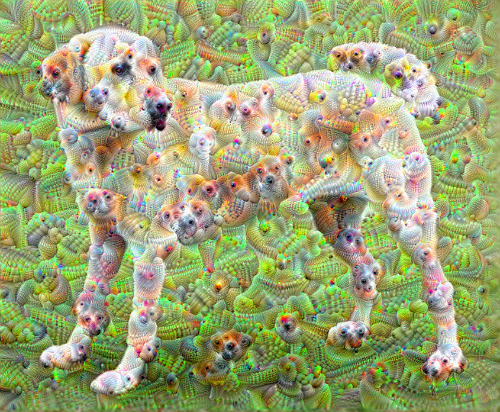

9.341618776321411

In [15]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2,3):
  new_shape = tf.cast(float_base_shape * (OCTAVE_SCALE **n), tf.int32)
  
  img = tf.image.resize(img,new_shape).numpy()
  
  img = run_deep_dream_simple(img=img,steps=50,step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img,base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

###可选：按比例放大
要考虑的一件事是，随着图像尺寸的增加，执行梯度计算所需的时间和内存也将随之增加。上面的倍频程实现不适用于非常大的图像或许多倍频程。

为避免此问题，您可以将图像拆分为图块并为每个图块计算梯度。

在每次平铺计算之前对图像应用随机移位可防止出现平铺接缝。

首先实现随机移位：

In [0]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll,maxval=maxroll,dtype=tf.int32)
  shift_down, shift_right = shift[0],shift[1]
  img_rolled = tf.roll(tf.roll(img,shift_right,axis=1),shift_down,axis=0)
  return shift_down,shift_right,img_rolled

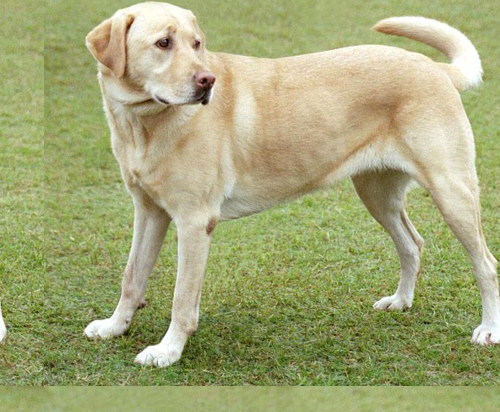

In [17]:
shift_down,shift_right,img_rolled = random_roll(np.array(original_img),512)
show(img_rolled)

这是deepdream先前定义的函数的平铺等效项：

In [0]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
          tf.TensorSpec(shape=[None,None,3],dtype=tf.float32),
          tf.TensorSpec(shape=[],dtype=tf.int32),
      )
  )
  def __call__(self,img,tile_size=512):
    shift_down,shift_right,img_rolled = random_roll(img,tile_size)

    #Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    # Skip the last tile,unless there's only one tile.
    xs = tf.range(0,img_rolled.shape[0],tile_size)[:-1]
    if not tf.cast(len(xs),bool):
      xs = tf.constant([0])
    ys = tf.range(0,img_rolled.shape[1],tile_size)[:-1]
    if not tf.cast(len(ys),bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        with tf.GradientTape() as tape:
          tape.watch(img_rolled)

          img_tile = img_rolled[x:x+tile_size,y:y+tile_size]
          loss = calc_loss(img_tile,self.model)

        gradients = gradients + tape.gradient(loss, img_rolled)
    gradients = tf.roll(tf.roll(gradients,-shift_right,axis=1),-shift_down,axis=0)

    gradients /= tf.math.reduce_std(gradients) + 1e-8

    return gradients

In [0]:
get_tiled_gradients = TiledGradients(dream_model)

将它们放在一起可提供可扩展的，感知八度音阶的Deepdream实现：

In [0]:
def run_deep_dream_with_octaves(img,steps_per_octave=100,step_size=0.01,
                                octaves=range(-2,3),octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img,initial_shape)
  for octave in octaves:
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]),tf.float32)* (octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size,tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img)
      img = img + gradients * step_size
      img = tf.clip_by_value(img,-1,1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print("Octave {} , Step {}".format(octave,step))

  result = deprocess(img)
  return result

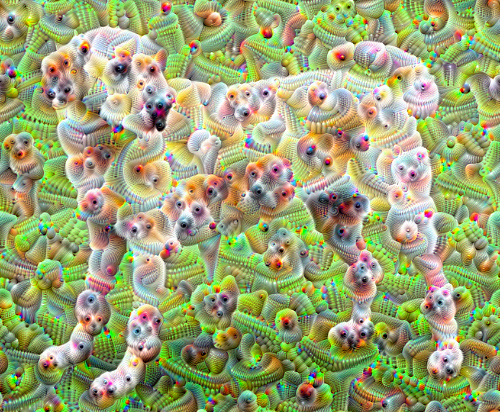

In [29]:
img = run_deep_dream_with_octaves(img=original_img,step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img,base_shape)
img = tf.image.convert_image_dtype(img/255.0,dtype=tf.uint8)
show(img)

好多了！播放八度音阶数，八度音阶和激活的图层，以更改DeepDream编辑的图像的外观。

读者可能也对[TensorFlow Lucid](https://github.com/tensorflow/lucid)感兴趣，它扩展了本教程中介绍的可视化和解释神经网络的思想。